# Dataset Verona Card

Struttura del file contenete i dati delle strisciate della verona card:

|campo  | label	| descrizione	|
|-----|-----|-------------------|
|0	| attivazione	| data di attivazione della verona card	|
|1	| id_vc	| codice identificativo della verona card	|
|2	| istante	| data ed ora di utilizzo della verona card|
|3  | profilo | formato della verona card (validità 24 o 72 ore)|
|4	| poi	| codice del punto di interesse in cui è stata utilizzata	|
|5	| classid	| identificativo della strisciata iniviato dal server per la raccolta dei dati	|

Load dei dati:

In [1]:
base_dir = 'dataset/'

filename_vc = base_dir + 'veronaCard.csv'
file_vc = sc.textFile(filename_vc)

header = file_vc.first()

data_vc = file_vc.filter(lambda row: row != header).map(lambda row : row.split(","))

data_vc.persist()

#data_vc.take(5)

PythonRDD[3] at RDD at PythonRDD.scala:53

### Q1
Per ogni Verona Card, il numero di punti di interesse (Points of Interest, PoI) visitati, da cui costruire la sua distribuzione (l'asse x contiene il numero di PoI, l'asse Y la percentuale di Verona Card usate per quel numero di PoI);

In [9]:
#togliere le tuple con un id_vc non valido
#creo la chiave (id_vc, attivazione) e assegno 1 ##################################
#per poter poi procedere con la conta di poi visitati (reduceByKey )
poi_visited_vc = data_vc.filter(lambda x: len(x[1]) > 5)\
                .map(lambda x: ((x[1],x[0]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .sortBy(lambda x: x[1],ascending = False)
#poi_visited_vc = per ogni verona card il numero di poi visitati

#poi_visited_vc.take(10)

In [10]:
tot_vc = poi_visited_vc.count() #numero totale di verona card

vc_same_poi_visited = poi_visited_vc.map(lambda x: (x[1],1))\
                                    .reduceByKey(lambda a,b: a+b)\
                                    .sortByKey()

#vc_same_poi_visited = (numero poi visitati, 
#                        conteggio vc che hanno visitato il quel numero di poi)


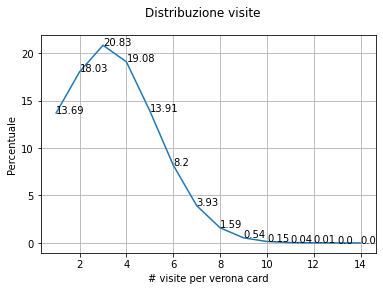

In [4]:
import matplotlib.pyplot as plt

list_vc_poi_visited = vc_same_poi_visited.collect()

perc_vc = [ (x[1] / tot_vc * 100) for x in list_vc_poi_visited]
visit_number = [x[0] for x in list_vc_poi_visited]

plt.suptitle('Distribuzione visite')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number, perc_vc)
for x,y in zip(visit_number, perc_vc):
    plt.text(x,y, str(round(y,2)))

plt.show()

----------------------------------------------------------------
### Q2
Per ogni PoI, la distribuzione del numero di visite giornaliere (l'asse x indica il range di visitatori, l'asse y la percentuali di giorni che quel PoI ha ricevuto un numero di visitatori all'interno di quel range);

In [3]:
#tolgo le tuple con id_vc non valido
#creao la chiave (poi, data di strisciata) e assegno 1
#conta delle visite giornalire (reduceByKey)
count_daily_visitors = data_vc.filter(lambda x: len(x[1]) > 5)\
                            .map(lambda x: ((x[4],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .sortBy(lambda x: x[1],ascending = False)

#count_daily_visit.take(10)

list_poi = data_vc.map(lambda x: x[4]).distinct().collect()

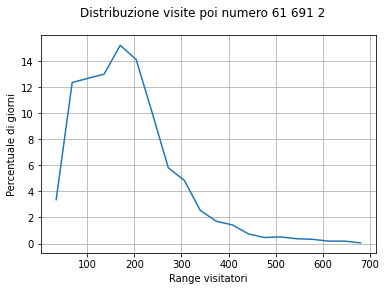

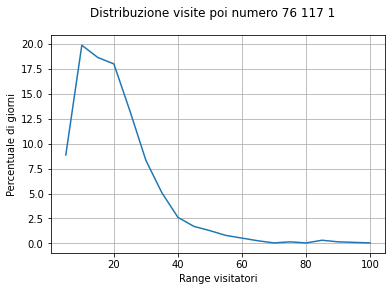

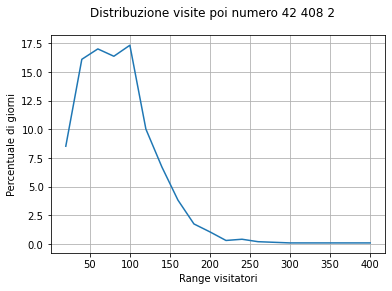

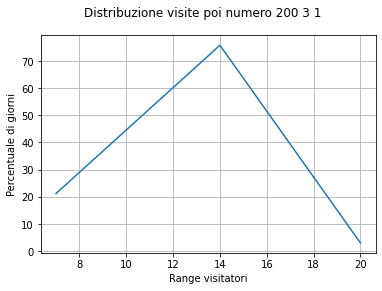

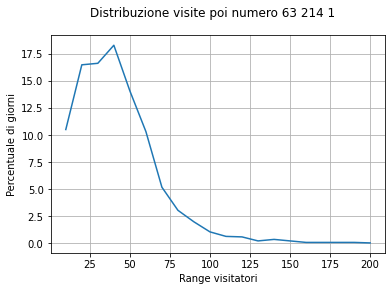

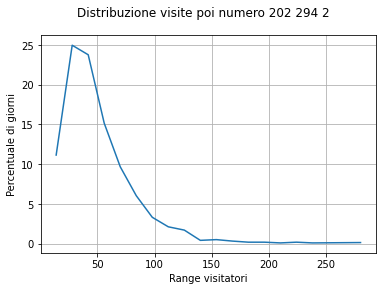

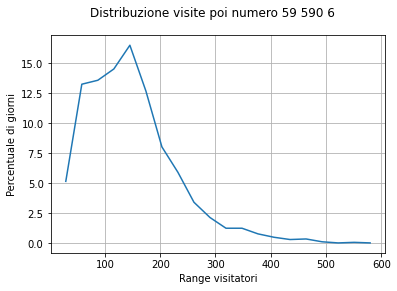

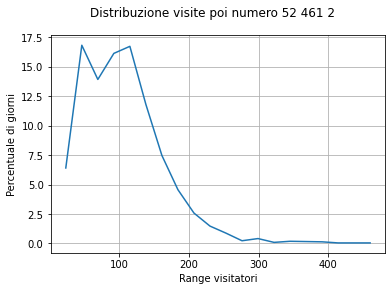

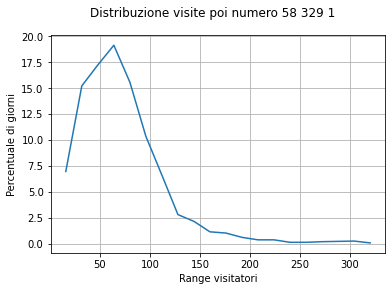

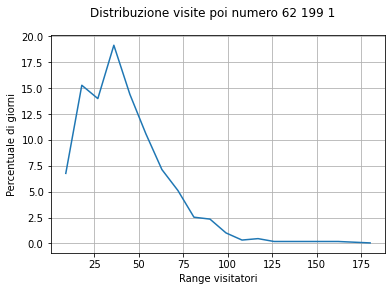

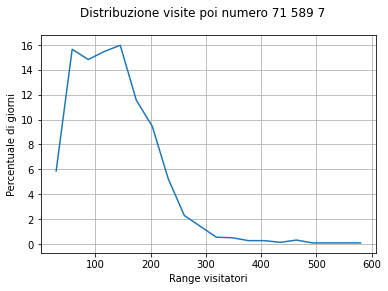

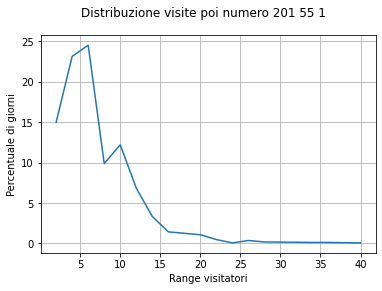

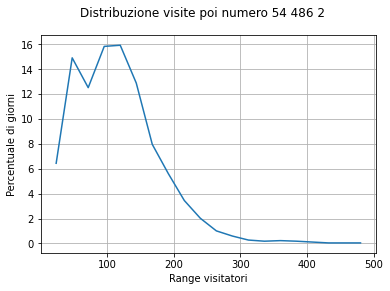

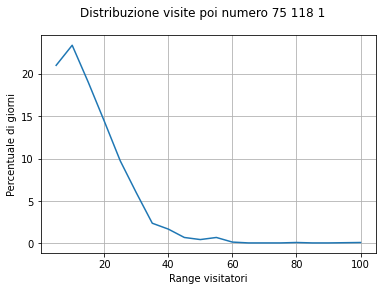

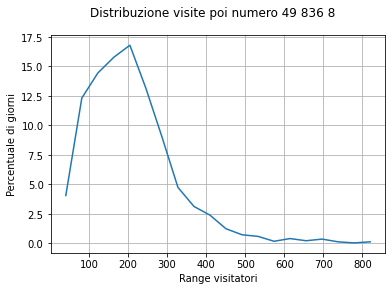

In [4]:
import matplotlib.pyplot as plt

number_bucket = 20

def get_bucket(visitors, max_v):
    if max_v == visitors:
        return number_bucket
    
    bucket = max_v/number_bucket
    return int(visitors / bucket) +1

for poi in list_poi:
    count_daily = count_daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    
    max_visitors = count_daily.map(lambda x: x[1]).max()
    min_visitors = count_daily.map(lambda x: x[1]).min()
    tot_visitors = count_daily.count()
    
    group_same_count_visitors = count_daily.map(lambda x: (get_bucket(x[1],max_visitors), 1))\
                                            .reduceByKey(lambda a,b: a+b)\
                                            .sortByKey()\
                                            .collect()
    bucket = max(int(max_visitors/number_bucket), 1)
    visitors = [ (x[1] / tot_visitors * 100) for x in group_same_count_visitors]
    bucket = [ x[0]*bucket  for x in group_same_count_visitors]
    
    #x_labels = [int((x[0]-1)*(max_visitors / number_bucket))+min_visitors for x in group_same_count_visitors]
    #x_labels =  range(min_visitors, max_visitors+1, int(max_visitors/number_bucket))
    #print(len(bucket), len(x_labels))
    #plt.xticks(range(number_bucket), x_labels)
    
    plt.suptitle('Distribuzione visite poi numero {} {} {}'.format(poi,max_visitors,min_visitors))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket,visitors)
    #for x,y in zip(bucket,visitors):
        #plt.text(x,y, str(round(y,2)))
    plt.show()


------------------------------------------------------------
---------------------------------------------------------------

# Dataset Stazioni metereologiche

Struttura del file contenete i dati delle stazioni metereologiche di Verona:

|campo  | label	| descrizione	|
|-----|-----|-------------------|
|0	| data	| data del rilevamento	|
|1	| ora	| ora del rilevamento	|
|2	| t	| temperatura in gradi centigradi |
|3  | ur | |
|4	| pr	| pressione atmosferica	|
|5	| wind	| vento in km/h	|
|6	| wind_dir	| direzione del vento	|
|7	| rain	| millimetri di pioggia	|
|8	| dp	| 	|
|9	| idstazione | id della stazione metereologica da cui sono stati rilevati i dati	|

Load dei dati:

In [2]:
base_dir = 'dataset/'

filename_w = base_dir+"meteo.csv"
file_w = sc.textFile(filename_w)

# extract header
#header = rawData.first() 

# remove the header, separate the elements for each row
#data_weather = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
data_weather = file_w.map(lambda row : row.split(","))\
                .map(lambda x: (x[0],x[1],float(x[2]),float(x[7])))

#pulizia da dati non validi
def verify_hour(ora):
    try:
        if int(ora.split('.')[0])<24:
            return True
        return False
    except:
        return False
    
data_w = data_weather.filter(lambda x: verify_hour(x[1]))

data_w.persist()

#data_w.take(5)

PythonRDD[6] at RDD at PythonRDD.scala:53

### C1
Giorni in cui ha piovuto per almeno X ore / giorni in cui ha piovuto meno di X ore

In [3]:
#media mm di pioggia rilevati ad ogni ora##############################################media o max
group_h_r = data_w.map(lambda x: ((x[0],int(x[1].split('.')[0])),x[3]) )\
                .reduceByKey(lambda a,b : round((a+b) / 2, 2))\
                    #.sortByKey(False)
#group_h.take(28)

#se ha piovuto 1 se non ha piovuto 0
rain_or_not_h = group_h_r.map(lambda x: (x[0][0], 1 if x[1]>0 else 0))#.sortByKey()

#sommo le ore di pioggia per giorno
day_rain = rain_or_not_h.reduceByKey(lambda a,b: a+b)


mean_rain = round(day_rain.map(lambda x: x[1]).mean(), 2)
print('ore medie annue di pioggia per giorno: ', mean_rain)

ore medie annue di pioggia per giorno:  19.23


In [4]:
#funzione che restituisce una tupla con due rdd, 
#uno contenente i giorni in cui ha piovuto meno di X ore, 
#uno contenente i giorni in cui ha piovuto più di X ore
def rain_hour(X_ore_rain):
    over_X = day_rain.filter(lambda x: x[1] >= X_ore_rain)#\
                    #.map(lambda x: x[0])

    under_X = day_rain.filter(lambda x: x[1] < X_ore_rain)#\
                    #.map(lambda x: x[0])
    return (over_X, under_X)


giorni in cui ha piovuto più di 19.23 ore
[('2016-01-11', 24), ('2016-01-18', 24), ('2016-02-12', 24), ('2016-06-02', 24), ('2016-08-05', 24)]
giorni in cui ha piovuto meno di 19.23 ore
[('2017-01-30', 15), ('2017-07-29', 1), ('2017-11-24', 0), ('2017-12-20', 1), ('2018-01-13', 0)]


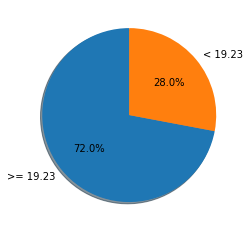

In [6]:
#esempio di esecuzione con le ore medie di tutto l'anno
over_X, under_X = rain_hour(mean_rain)

print('giorni in cui ha piovuto più di {} ore'.format(mean_rain))
print(over_X.take(5))

print('giorni in cui ha piovuto meno di {} ore'.format(mean_rain))
print(under_X.take(5))

import matplotlib.pyplot as plt

labels = '>= {}'.format(mean_rain), '< {}'.format(mean_rain)
sizes = [over_X.count(),under_X.count()]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

-----------------------------------------
### C2

Giorni in cui la temperatura media era superiore a Y / giorni in cui era inferiore a Y

In [38]:
#temperatura media oraria
group_h_t = data_w.map(lambda x: ((x[0],int(x[1].split('.')[0])),x[2]) )\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                #.sortByKey()

#print(group_h.take(28))

#temperaturra media giornaliera
day_t_mean = group_h_t.map(lambda x: (x[0][0],x[1]))\
                    .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                    #.sortByKey()
#print(day_t_mean.take(35))


mean_t = round(day_t_mean.map(lambda x: x[1]).mean(), 2)
print('temperatura media giornaliera annua: ', mean_t)

temperatura media giornaliera annua:  13.69


In [41]:
#funzione che restituisce una tupla con due rdd, 
#uno contenente i giorni in cui la temperatura media era superiore a Y, 
#uno contenente i giorni in cui la temperatura media era inferiore a Y
def temperature_day(Y_t):
    over_Y = day_t_mean.filter(lambda x: x[1] >= Y_t)\
                        .map(lambda x: x[0])

    under_Y = day_t_mean.filter(lambda x: x[1] < Y_t)\
                        .map(lambda x: x[0])
    
    return (over_Y, under_Y)



giorni in cui la temperatura era più alta di 13.69 
['2016-06-02', '2016-08-05', '2016-08-16', '2016-09-30', '2016-10-03']
giorni in cui la temperatura era più bassa di 13.69 
['2016-01-11', '2016-01-18', '2016-02-12', '2016-10-29', '2016-11-21']


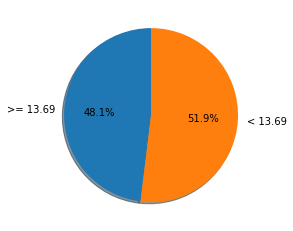

In [47]:
#esempio di esecuzione con la temperatura media
over_Y, under_Y = temperature_day(mean_t)

print('giorni in cui la temperatura era più alta di {} '.format(mean_t))
print(over_Y.take(5))

print('giorni in cui la temperatura era più bassa di {} '.format(mean_t))
print(under_Y.take(5))


import matplotlib.pyplot as plt

labels = '>= {}'.format(mean_t), '< {}'.format(mean_t)
sizes = [over_Y.count(),under_Y.count()]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

# Dataset Verona Card e Stazioni Metereologiche

## Pioggia
Ricalcola Q1 e Q2 considerando la suddivisione in C1 (per alcuni valori di X scelti da te) e confronta le distribuzioni nei giorni in cui ha piovuto / non ha piovuto per X ore.

### Q1 + C1

In [26]:
def get_visit_date(date):
    day, month, year = date.split(' ')[0].split('/')
    return '-'.join([year, month, day])

poi_visited_vc_day_use = data_vc.filter(lambda x: len(x[1]) > 5)\
                .map(lambda x: ((get_visit_date(x[2]),x[1]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0][0],(x[0][1],x[1])))

over_X, under_X = rain_hour(mean_rain)

#lo faccio per giorno!! non più per tutta la durata della vc
over_poi_visited = poi_visited_vc_day_use.join(over_X)\
                                        .map(lambda x: x[1][0])\
                                        .map(lambda x: (x[1],1))\
                                        .reduceByKey(lambda a,b: a+b)

#over_poi_visited.take(5) [('2017-10-28', (('04DB98429C4C80', 3), 22)),('2017-10-28', (('0435D33A9C4C80', 5), 22)),

#over_poi_visited.collect()

under_poi_visited = poi_visited_vc_day_use.join(under_X)\
                                        .map(lambda x: x[1][0])\
                                        .map(lambda x: (x[1],1))\
                                        .reduceByKey(lambda a,b: a+b)
#under_poi_visited.collect()

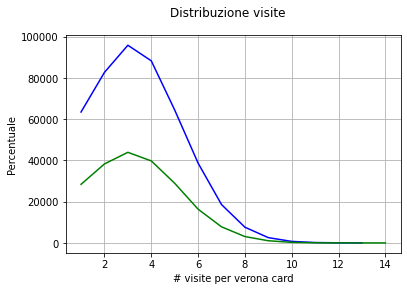

In [27]:
import matplotlib.pyplot as plt

list_over = over_poi_visited.collect()
list_under = under_poi_visited.collect()

perc_vc_over = [ (x[1] ) for x in list_over]
perc_vc_under = [ (x[1] ) for x in list_under]
visit_number_over = [x[0] for x in list_over]
visit_number_under = [x[0] for x in list_under]

plt.suptitle('Distribuzione visite')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
#plt.plot(visit_number, perc_vc)
#for x,y in zip(visit_number, perc_vc):
#    plt.text(x,y, str(round(y,2)))
plt.plot(visit_number_over,perc_vc_over, color='b')
plt.plot(visit_number_under,perc_vc_under, color='g')
#plt.legend()

plt.show()

--------------------------------------------------------
### Q2 + C1

In [11]:
###da fare

import matplotlib.pyplot as plt

number_bucket = 20

def get_bucket(visitors, max_v):
    if max_v == visitors:
        return number_bucket
    
    bucket = max_v/number_bucket
    return int(visitors / bucket) +1

for poi in list_poi:
    count_daily = count_daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    
    max_visitors = count_daily.map(lambda x: x[1]).max()
    min_visitors = count_daily.map(lambda x: x[1]).min()
    tot_visitors = count_daily.count()
    
    group_same_count_visitors = count_daily.map(lambda x: (get_bucket(x[1],max_visitors), 1))\
                                            .reduceByKey(lambda a,b: a+b)\
                                            .sortByKey()\
                                            .collect()
    bucket = max(int(max_visitors/number_bucket), 1)
    visitors = [ (x[1] / tot_visitors * 100) for x in group_same_count_visitors]
    bucket = [ x[0]*bucket  for x in group_same_count_visitors]
    
    #x_labels = [int((x[0]-1)*(max_visitors / number_bucket))+min_visitors for x in group_same_count_visitors]
    #x_labels =  range(min_visitors, max_visitors+1, int(max_visitors/number_bucket))
    #print(len(bucket), len(x_labels))
    #plt.xticks(range(number_bucket), x_labels)
    
    plt.suptitle('Distribuzione visite poi numero {} {} {}'.format(poi,max_visitors,min_visitors))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket,visitors)
    #for x,y in zip(bucket,visitors):
        #plt.text(x,y, str(round(y,2)))
    plt.show()


NameError: name 'list_poi' is not defined

--------------------------------------------------
-----------------------------------------------------
## Temperatura
Ricalcola Q1 e Q2 considerando la suddivisione in C2 (per alcuni valori di Y scelti da te) e confronta le distribuzioni nei giorni in cui la temperatura era maggiore / minore di Y.

### Q1 + C2

--------------------------------------------------------
### Q2 + C2